# Test sampling algorithms

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import scipy.interpolate
import ultraplot as plt
from tqdm import tqdm

import ment

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

Create a particle distribution.

In [3]:
# Settings
ndim = 4
size = 1_000_000
n_modes = 5
seed = 1241

# Create gaussian particle distribution
rng = np.random.default_rng(seed)
mean = np.zeros(ndim)
cov = np.identity(ndim)
for i in range(ndim):
    for j in range(i):
        cov[i, j] = cov[j, i] = rng.uniform(-0.4, 0.4)
x = rng.multivariate_normal(mean, cov, size=size)

# Add gaussian blobs
for _ in range(n_modes):
    scale = rng.uniform(0.8, 1.5, size=ndim)
    loc = rng.uniform(-5.0, 3.0, size=ndim)
    x = np.vstack([x, rng.normal(loc=loc, scale=scale, size=(size // n_modes, ndim))])
x = x - np.mean(x, axis=0)

rng.shuffle(x)

x_true = np.copy(x)

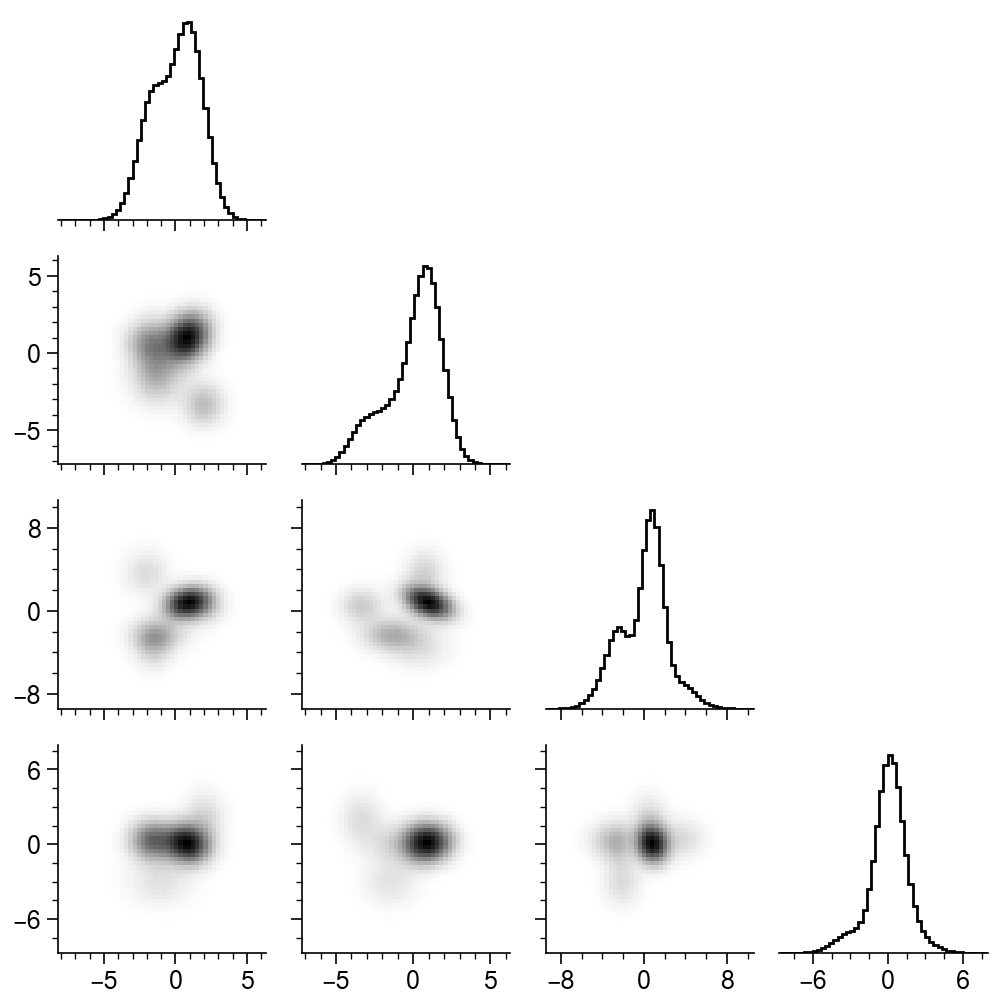

In [4]:
limits = ps.limits(x_true)

grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
grid.plot(
    x_true,
    bins=50,
    limits=limits,
    cmap="mono",
)
plt.show()

Compute ground-truth histogram.

In [5]:
n_bins = 25
values, edges = np.histogramdd(x_true, bins=n_bins, range=limits, density=True)
hist = ps.Histogram(values=values, edges=edges)
print("hist.shape =", hist.shape)

hist.shape = (25, 25, 25, 25)


Interpolate to obtain a smooth density function.

In [6]:
prob_func = scipy.interpolate.RegularGridInterpolator(
    hist.coords,
    hist.values,
    method="linear",
    bounds_error=False,
    fill_value=0.0,
)

## Grid Sampling (GS)

In [7]:
samp_grid_res = 15  # limit ~ 15
grid_shape = [samp_grid_res] * ndim
grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    noise=0.0,
)

start_time = time.time()
x_samp = sampler(prob_func, size)

print("time:", time.time() - start_time)

time: 0.16556096076965332


Plot a samples over histogram projections.

In [8]:
def plot_corner_samp(x_samp: np.ndarray):
    limits = ps.limits(x_true, rms=2.5)

    grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
    grid.set_limits(limits)
    grid.plot_hist(hist, cmap="mono")
    grid.plot(x_samp[:, :], kind="hist", alpha=0.0, diag_kws=dict(color="red"))
    grid.plot(
        x_samp[:1000, :],
        diag=False,
        kind="scatter",
        color="red",
        s=0.25,
    )
    return grid

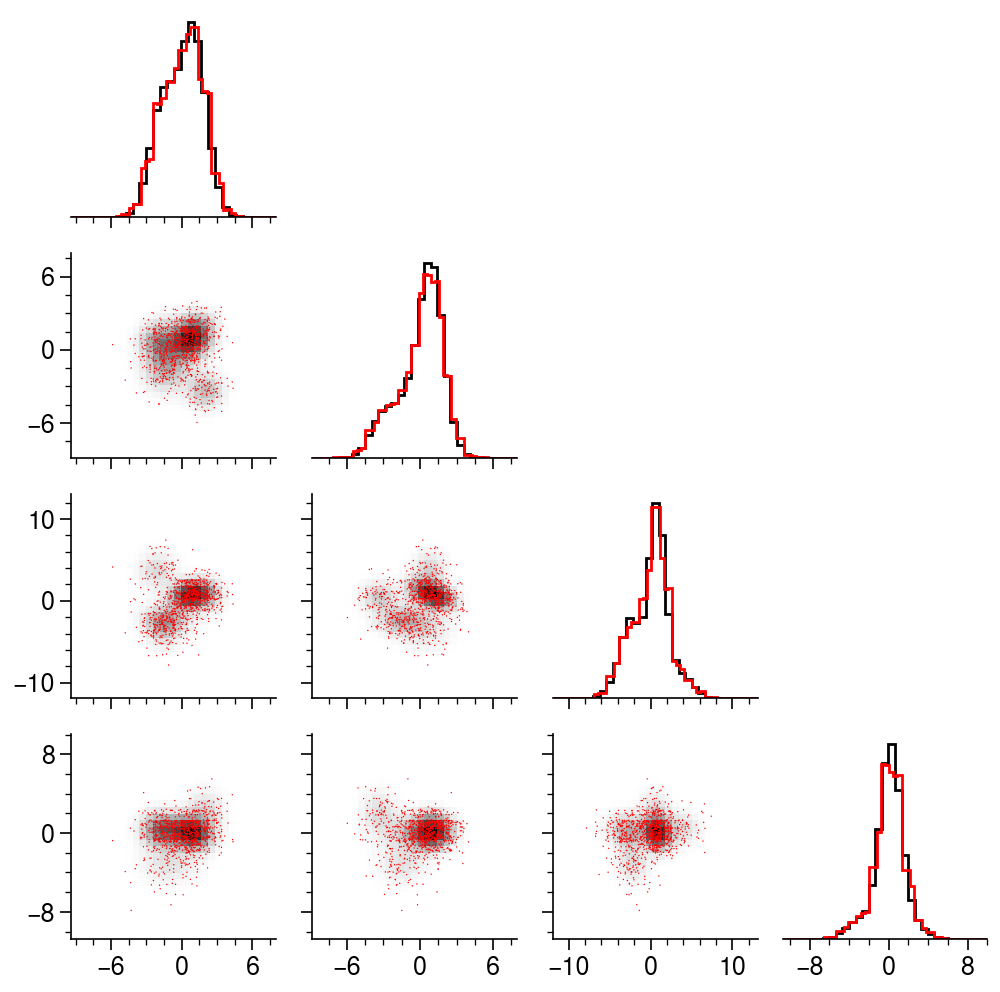

In [9]:
grid = plot_corner_samp(x_samp)

## Slice Grid Sampling (GS)

In [10]:
samp_res = 20
int_res = 10

ndim_proj = 2
ndim_samp = ndim_int = ndim - ndim_proj

grid_shape = [samp_res] * ndim
grid_limits = limits
int_size = int(int_res**ndim_int)

sampler = ment.samp.SliceGridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    proj_dim=ndim_proj,
    int_size=int_size,
    int_method="grid",
    int_batches=1,
    noise=0.0,
    verbose=True,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

Projecting


  0%|                                                                                                                            | 0/400 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 9596.91it/s]

Sampling


0it [00:00, ?it/s]

272it [00:00, 2687.00it/s]

400it [00:00, 3006.41it/s]

time: 0.9634568691253662


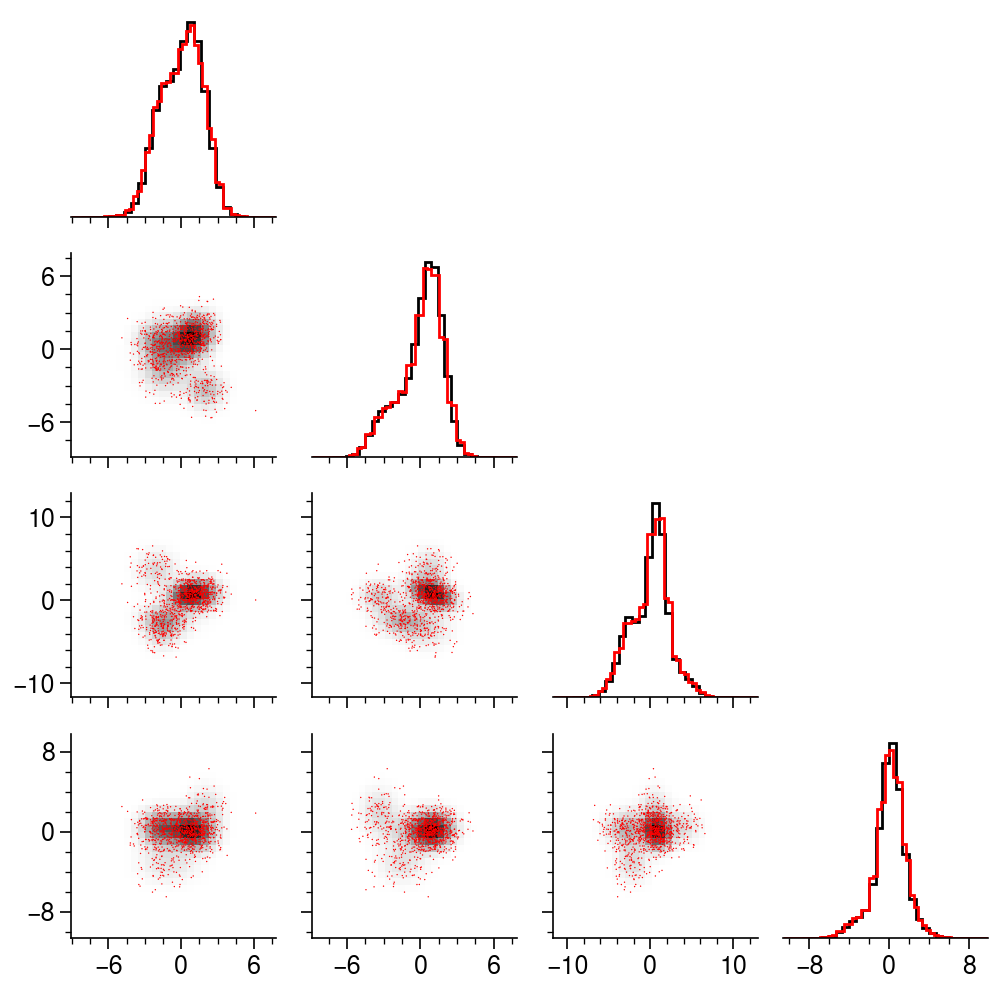

In [11]:
grid = plot_corner_samp(x_samp)

## Metropolis-Hastings

In [12]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=1,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                         | 0/100999 [00:00<?, ?it/s]

  1%|█▎                                                                                                         | 1229/100999 [00:00<00:08, 12284.83it/s]

  2%|██▌                                                                                                        | 2477/100999 [00:00<00:07, 12398.25it/s]

  4%|███▉                                                                                                       | 3717/100999 [00:00<00:07, 12363.70it/s]

  5%|█████▎                                                                                                     | 4959/100999 [00:00<00:07, 12384.42it/s]

  6%|██████▌                                                                                                    | 6198/100999 [00:00<00:07, 12371.25it/s]

  7%|███████▉                                                                                                   | 7443/100999 [00:00<00:07, 12397.81it/s]

  9%|█████████▏                                                                                                 | 8695/100999 [00:00<00:07, 12436.29it/s]

 10%|██████████▌                                                                                                | 9939/100999 [00:00<00:07, 12379.55it/s]

 11%|███████████▋                                                                                              | 11179/100999 [00:00<00:07, 12384.34it/s]

 12%|█████████████                                                                                             | 12436/100999 [00:01<00:07, 12440.08it/s]

 14%|██████████████▎                                                                                           | 13682/100999 [00:01<00:07, 12443.47it/s]

 15%|███████████████▋                                                                                          | 14927/100999 [00:01<00:07, 12274.21it/s]

 16%|████████████████▉                                                                                         | 16155/100999 [00:01<00:06, 12201.12it/s]

 17%|██████████████████▏                                                                                       | 17383/100999 [00:01<00:06, 12224.41it/s]

 18%|███████████████████▌                                                                                      | 18613/100999 [00:01<00:06, 12244.71it/s]

 20%|████████████████████▊                                                                                     | 19854/100999 [00:01<00:06, 12292.22it/s]

 21%|██████████████████████▏                                                                                   | 21084/100999 [00:01<00:06, 12216.41it/s]

 22%|███████████████████████▍                                                                                  | 22326/100999 [00:01<00:06, 12274.46it/s]

 23%|████████████████████████▋                                                                                 | 23554/100999 [00:01<00:06, 12166.50it/s]

 25%|█████████████████████████▉                                                                                | 24771/100999 [00:02<00:06, 12090.85it/s]

 26%|███████████████████████████▎                                                                              | 26018/100999 [00:02<00:06, 12200.94it/s]

 27%|████████████████████████████▋                                                                             | 27278/100999 [00:02<00:05, 12317.05it/s]

 28%|█████████████████████████████▉                                                                            | 28542/100999 [00:02<00:05, 12410.79it/s]

 29%|███████████████████████████████▎                                                                          | 29784/100999 [00:02<00:05, 12375.39it/s]

 31%|████████████████████████████████▌                                                                         | 31033/100999 [00:02<00:05, 12407.72it/s]

 32%|█████████████████████████████████▉                                                                        | 32292/100999 [00:02<00:05, 12460.57it/s]

 33%|███████████████████████████████████▏                                                                      | 33539/100999 [00:02<00:05, 12299.73it/s]

 34%|████████████████████████████████████▌                                                                     | 34807/100999 [00:02<00:05, 12412.34it/s]

 36%|█████████████████████████████████████▊                                                                    | 36063/100999 [00:02<00:05, 12456.10it/s]

 37%|███████████████████████████████████████▏                                                                  | 37309/100999 [00:03<00:05, 12447.27it/s]

 38%|████████████████████████████████████████▍                                                                 | 38576/100999 [00:03<00:04, 12511.45it/s]

 39%|█████████████████████████████████████████▊                                                                | 39828/100999 [00:03<00:04, 12474.51it/s]

 41%|███████████████████████████████████████████▏                                                              | 41091/100999 [00:03<00:04, 12520.27it/s]

 42%|████████████████████████████████████████████▍                                                             | 42344/100999 [00:03<00:04, 12451.24it/s]

 43%|█████████████████████████████████████████████▊                                                            | 43593/100999 [00:03<00:04, 12459.97it/s]

 44%|███████████████████████████████████████████████                                                           | 44854/100999 [00:03<00:04, 12504.52it/s]

 46%|████████████████████████████████████████████████▍                                                         | 46105/100999 [00:03<00:04, 12488.46it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 47354/100999 [00:03<00:04, 12398.80it/s]

 48%|███████████████████████████████████████████████████                                                       | 48605/100999 [00:03<00:04, 12430.54it/s]

 49%|████████████████████████████████████████████████████▎                                                     | 49856/100999 [00:04<00:04, 12452.57it/s]

 51%|█████████████████████████████████████████████████████▋                                                    | 51102/100999 [00:04<00:04, 12451.08it/s]

 52%|██████████████████████████████████████████████████████▉                                                   | 52364/100999 [00:04<00:03, 12501.13it/s]

 53%|████████████████████████████████████████████████████████▎                                                 | 53634/100999 [00:04<00:03, 12557.96it/s]

 54%|█████████████████████████████████████████████████████████▌                                                | 54890/100999 [00:04<00:03, 12509.97it/s]

 56%|██████████████████████████████████████████████████████████▉                                               | 56152/100999 [00:04<00:03, 12539.14it/s]

 57%|████████████████████████████████████████████████████████████▎                                             | 57414/100999 [00:04<00:03, 12562.47it/s]

 58%|█████████████████████████████████████████████████████████████▌                                            | 58671/100999 [00:04<00:03, 12521.46it/s]

 59%|██████████████████████████████████████████████████████████████▉                                           | 59924/100999 [00:04<00:03, 12500.22it/s]

 61%|████████████████████████████████████████████████████████████████▏                                         | 61175/100999 [00:04<00:03, 12491.83it/s]

 62%|█████████████████████████████████████████████████████████████████▌                                        | 62425/100999 [00:05<00:03, 12445.46it/s]

 63%|██████████████████████████████████████████████████████████████████▊                                       | 63685/100999 [00:05<00:02, 12489.19it/s]

 64%|████████████████████████████████████████████████████████████████████▏                                     | 64940/100999 [00:05<00:02, 12505.35it/s]

 66%|█████████████████████████████████████████████████████████████████████▍                                    | 66191/100999 [00:05<00:02, 12369.41it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                   | 67429/100999 [00:05<00:02, 12349.41it/s]

 68%|████████████████████████████████████████████████████████████████████████                                  | 68675/100999 [00:05<00:02, 12380.62it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                | 69914/100999 [00:05<00:02, 12368.33it/s]

 70%|██████████████████████████████████████████████████████████████████████████▋                               | 71173/100999 [00:05<00:02, 12433.02it/s]

 72%|████████████████████████████████████████████████████████████████████████████                              | 72423/100999 [00:05<00:02, 12452.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▎                            | 73677/100999 [00:05<00:02, 12478.29it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▋                           | 74925/100999 [00:06<00:02, 12462.05it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                          | 76172/100999 [00:06<00:02, 12367.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▎                        | 77420/100999 [00:06<00:01, 12397.72it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▌                       | 78674/100999 [00:06<00:01, 12437.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▉                      | 79923/100999 [00:06<00:01, 12450.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▏                    | 81172/100999 [00:06<00:01, 12460.45it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 82419/100999 [00:06<00:01, 12325.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▊                  | 83676/100999 [00:06<00:01, 12395.29it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 84916/100999 [00:06<00:01, 12354.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 86168/100999 [00:06<00:01, 12402.58it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊              | 87428/100999 [00:07<00:01, 12458.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 88677/100999 [00:07<00:00, 12466.33it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▍           | 89924/100999 [00:07<00:00, 12339.28it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 91159/100999 [00:07<00:00, 12313.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▉         | 92393/100999 [00:07<00:00, 12318.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▎       | 93626/100999 [00:07<00:00, 12293.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▌      | 94856/100999 [00:07<00:00, 12264.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 96110/100999 [00:07<00:00, 12346.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97354/100999 [00:07<00:00, 12373.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98592/100999 [00:07<00:00, 12268.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99843/100999 [00:08<00:00, 12338.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100999/100999 [00:08<00:00, 12390.77it/s]

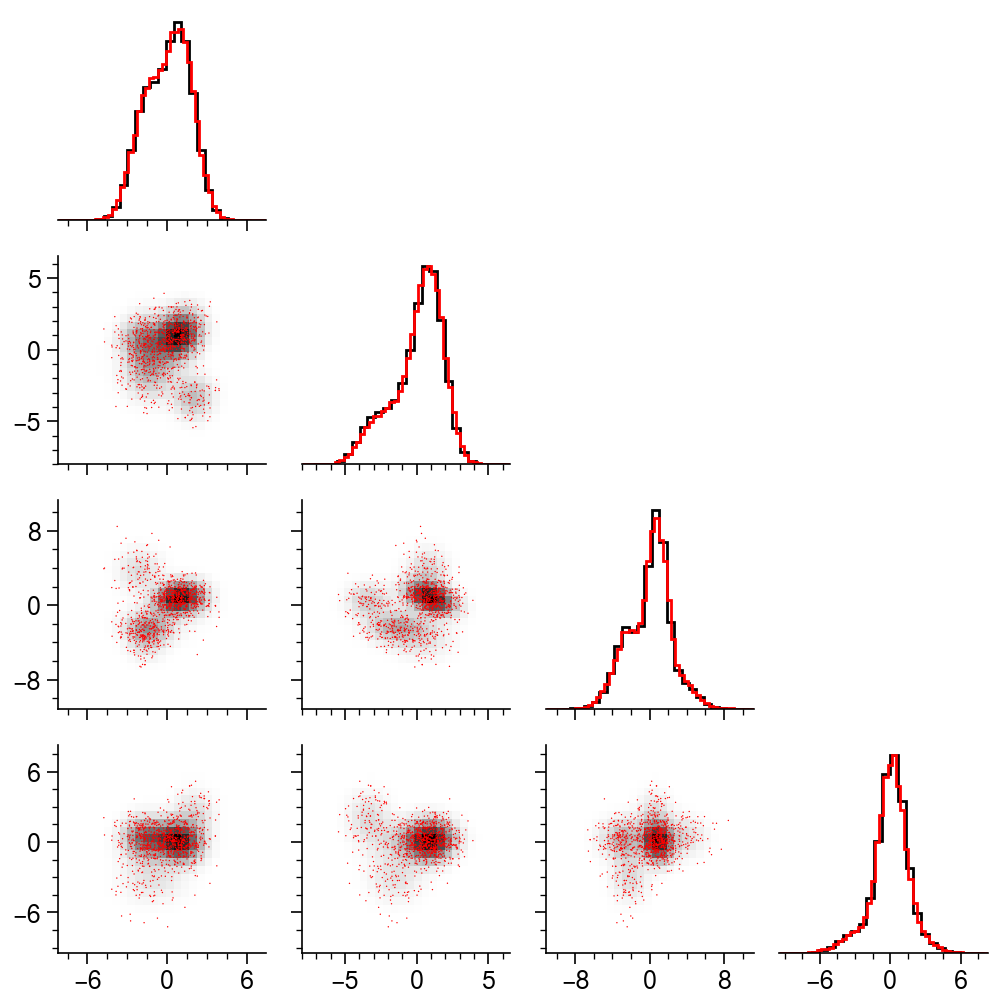

In [13]:
grid = plot_corner_samp(x_samp)

In [14]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=10,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                          | 0/10999 [00:00<?, ?it/s]

 10%|███████████▏                                                                                                | 1139/10999 [00:00<00:00, 11389.30it/s]

 21%|██████████████████████▌                                                                                     | 2300/10999 [00:00<00:00, 11518.72it/s]

 31%|█████████████████████████████████▉                                                                          | 3457/10999 [00:00<00:00, 11538.02it/s]

 42%|█████████████████████████████████████████████▎                                                              | 4616/10999 [00:00<00:00, 11556.13it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 5775/10999 [00:00<00:00, 11565.80it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 6939/10999 [00:00<00:00, 11588.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 8102/10999 [00:00<00:00, 11600.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 9266/10999 [00:00<00:00, 11610.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 10432/10999 [00:00<00:00, 11625.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10999/10999 [00:00<00:00, 11584.01it/s]

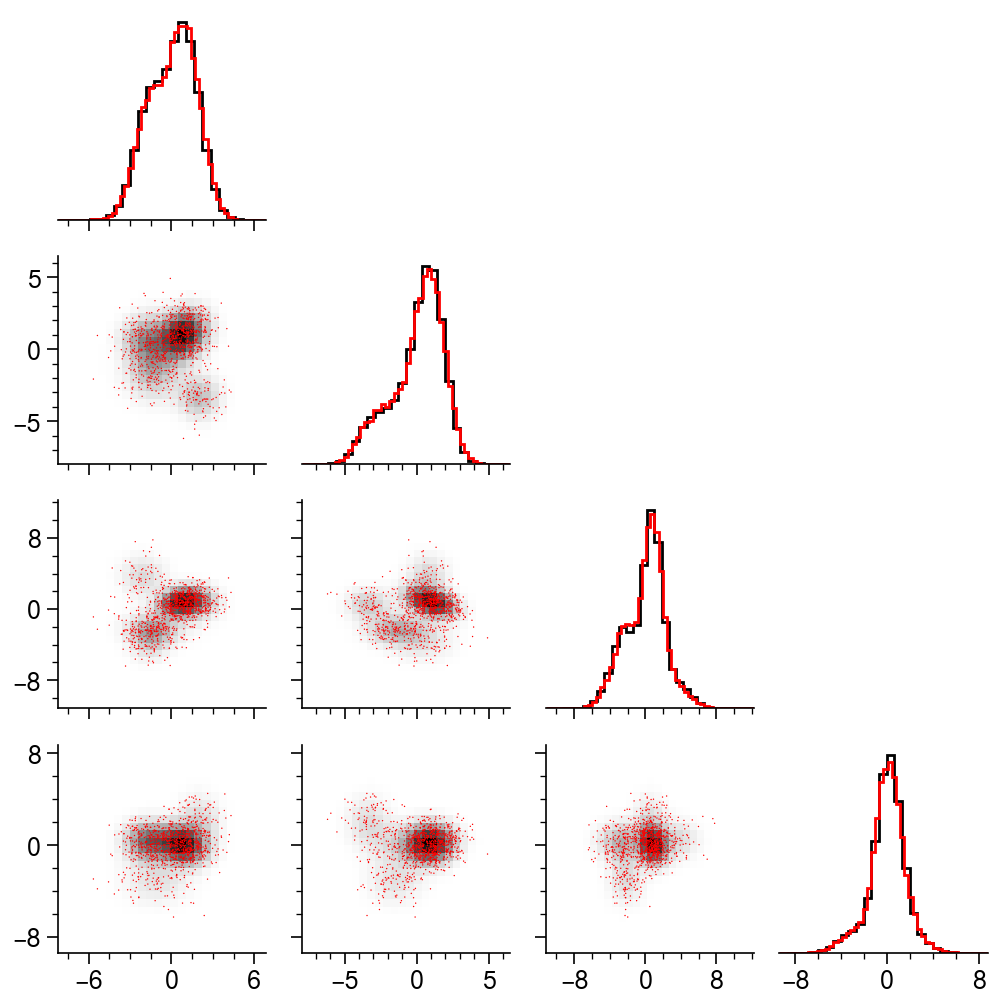

In [15]:
grid = plot_corner_samp(x_samp)